# Multivariate Time Series with RNN


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from khayyam import JalaliDate
from plotly.subplots import make_subplots
import warnings
from sklearn.model_selection import train_test_split  
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
# Ignore all warnings
warnings.filterwarnings("ignore")




## 1.Data preprocessing

In [3]:
df= pd.read_excel(r"C:\Users\ASUS\Desktop\parsiantejarat\data.xlsx")

In [4]:
df.columns = df.columns.str.replace("/", "-")
def shamsi_to_gregorian(column_name):
    if '-' in column_name: 
        year, month = map(int, column_name.split('-'))
        gregorian_date = JalaliDate(year, month, 1).todate()  
        return gregorian_date.strftime('%Y-%m')  
   

# Apply the conversion to the columns
df.columns = [shamsi_to_gregorian(col) for col in df.columns]
df_transposed=df.transpose()
df_transposed.columns = df_transposed.iloc[0]
df_last=df_transposed.iloc[1:]
df_last.index = pd.to_datetime(df_last.index.values, format='%Y-%m-%d', errors='coerce') 

In [8]:
# Notice the minus sign in our indexing

train = df_last.iloc[:20]
test = df_last.iloc[20:]

In [9]:
train

,تهران,آذربایجان شرقی,آذربایجان غربی,اردبیل,اصفهان,البرز,ایلام,بوشهر,چهارمحال و بختیاری,خراسان جنوبی,...,کهگیلویه و بویر احمد,گلستان,گیلان,لرستان,مازندران,مرکزی,هرمزگان,همدان,یزد,مجموع
2022-03-01,998039333.438655,205875461.209536,194948632.346491,67295484.85856,288588514.033838,146569727.461013,25817576.639376,103510917.296905,39669407.139775,28965670.517418,...,30267951.426113,87815004.950238,174593474.440285,66816373.728695,238671726.947429,61614669.855979,168582481.670376,76259679.51573,70833134.825824,4711607223.556961
2022-04-01,1403626873.897137,257001147.389894,222646228.038438,79874155.801504,360364753.31994,207105622.677179,32063905.154513,99645210.836531,49504848.244407,33152715.520902,...,32805806.249913,100510260.04746,194104488.71656,80988604.39831,277825741.105974,79049728.884862,157229066.127931,96580458.395352,84691081.215704,5789302831.537865
2022-05-01,1525571189.25532,271902670.727448,218107240.506329,85150577.3304,401540958.856239,228130610.866508,34374351.699977,96615266.582516,53675628.256673,35829600.534111,...,36515505.733402,114366129.240176,206006616.742218,85035993.182337,303134963.624486,87767525.53453,159194997.509476,102968086.226695,93145672.188646,6247241161.421834
2022-06-01,1478722755.867485,254798360.225536,204388148.084535,84292241.992548,376765873.196646,216985076.13549,31600097.77092,85509238.229873,51079268.218568,35010053.970666,...,35832036.177507,115114299.595198,193576646.662212,83871863.998117,289522150.413329,82851446.12707,141369127.267057,99309781.164529,86959922.131398,5930504059.921055
2022-07-01,1395127766.637122,248812482.722676,212027253.993415,84284443.359207,372683242.677497,203474616.900531,30945944.980605,82202508.941126,50800587.313194,33637342.788844,...,35490534.571144,104367654.256342,191920798.78153,85532586.254008,287916466.623575,80773585.044928,133925892.036309,100444244.076928,80830944.148708,5747216635.687351
2022-08-01,1501553606.452262,268385151.710758,230517866.334884,90479739.404488,385191365.741246,214264104.292218,32526985.040259,88572426.513001,53853337.908944,35000231.664419,...,38193259.572588,112013186.818839,231416928.575965,88789942.486028,324388164.675493,84981412.840477,151279473.215645,106979986.049696,87262124.861574,6161679873.581699
2022-09-01,1429786881.353193,268929842.445901,238103015.306208,89251911.145968,372888012.216572,208552049.65836,31169742.353549,91926275.837774,51612134.629329,34178609.154583,...,37181693.200053,115057735.413089,219679981.638421,90919713.091008,306041383.002,86768924.320109,154131002.988575,109976278.263472,84219874.561319,6053795194.559947
2022-10-01,1607686720.682647,292978118.767088,255114042.968439,92096384.425875,405625041.144363,223962710.696762,33495763.468641,102579672.194197,53278456.541456,38013443.244157,...,39497836.11124,122027696.54207,215557976.139137,95579354.617832,318716738.537307,91491674.040505,168143731.176462,114942646.010779,94183256.7209,6553566286.254184
2022-11-01,1740850601.57651,313567152.81541,281425650.328913,95730780.715979,449150357.012647,245986726.863227,37453120.583759,113328099.239578,57257695.049229,41536406.106973,...,41108986.881702,128737979.500477,229033608.594513,103294655.131935,346701568.199162,99163892.553435,185860615.460573,120698085.555558,101831336.157473,7125906639.43639
2022-12-01,1796300974.94633,312936649.677589,295155786.44858,94501601.821552,440677709.079705,245724140.784264,37595731.407077,114964932.549443,53115266.648265,41094276.194566,...,39878223.145794,131985345.443638,239381609.889754,100228454.413789,361590312.931176,96468377.937788,203530301.108213,111541007.16519,99758484.822373,7198089641.705729


In [10]:
test

,تهران,آذربایجان شرقی,آذربایجان غربی,اردبیل,اصفهان,البرز,ایلام,بوشهر,چهارمحال و بختیاری,خراسان جنوبی,...,کهگیلویه و بویر احمد,گلستان,گیلان,لرستان,مازندران,مرکزی,هرمزگان,همدان,یزد,مجموع
2023-11-01,2042365685.145955,368934640.61071,316834049.738789,113213976.89139,524716806.236484,289225413.400442,42805437.934077,127508682.215485,70415214.73588,50382440.627179,...,49529850.250762,156294646.880433,276584585.664674,123162773.666713,415316128.842057,117081631.243608,257992849.525178,139341925.241224,125298562.034495,8457885204.084438
2023-12-01,2045954579.874464,351157616.137109,293916810.353055,102889063.750059,527734780.048947,281592115.468826,41491795.58858,133262028.72965,68403736.23834,50204891.558563,...,48350469.656124,151542202.464135,265332016.131016,113333344.419134,405367965.842398,111711206.37287,260670422.132411,130153042.350004,127772171.700396,8289609728.094483
2024-01-01,2167120022.025641,356559816.03385,292807694.228397,108181514.444722,542280637.293233,290653520.478678,43029421.723637,143653912.482905,69778780.35426,51258622.26902,...,49545358.227318,150342120.888727,280331905.200506,116437471.912616,425501768.039688,115122411.897841,298286766.360848,132267091.202741,130990844.985036,8613289888.130478
2024-02-01,2795459033.87058,481696266.300162,369966699.628096,146639337.197898,687267355.455282,398608706.555262,56857245.54962,167364223.947846,98200689.735889,62700145.794557,...,61909572.47387,189505649.855273,350120005.167346,165015592.534187,543543108.526482,154940408.147057,321920956.465215,181497850.771568,167381018.539086,10918507216.936815


In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## 2.Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.


In [16]:
# define generator
length = 12 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [17]:
len(scaled_train)

20

In [18]:
len(generator) 

8

In [19]:
# What does the first batch look like?
X,y = generator[0]

In [20]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.         0.         0.         0.         0.
 0.         0.29741375 0.         0.         0.         0.
 0.         0.         0.         0.07658007 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.24655711 0.
 0.         0.         0.26259163 0.22758289 0.17487455 0.19452319
 0.20408816 0.27523533 0.26999085 0.24345785 0.22226362 0.15135592
 0.18661248 0.13904039 0.21099651 0.24602989 0.20176385 0.12683757
 0.19684209 0.23776345 0.22459051 0.22043428 0.18986336 0.23337625
 0.10776498 0.14730677 0.1226421  0.17290529 0.13752518 0.21788843
 0.16578559 0.22526238 0.18179482 0.20452751 0.34154266 0.29391612
 0.1462167  0.27612055 0.32116836 0.37082852 0.36985743 0.20116717
 0.31651589 0.24812163 0.31283961 0.23512901 0.35217121 0.34568908
 0.34348997 0.20815254 0.30238079 0.35553048 0.35477826 0.18943515
 0.26305932 0.30947863 0.26529003 0.30808049 0.19745635 0.2222846
 0.2264217  0.3268

Now you will be able to edit the length so that it makes sense for your time series!

## 3.Create the Model

In [22]:
scaled_train.shape

(20, 32)

In [23]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
Total params: 56432 (220.44 KB)
Trainable params: 56432 (220.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:

early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_train,scaled_train, 
                                           length=length, batch_size=batch_size)

In [27]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10
8/8 [==============================] - 4s 217ms/step - loss: 0.2684 - val_loss: 0.0637
Epoch 2/10
8/8 [==============================] - 0s 20ms/step - loss: 0.0253 - val_loss: 0.0234
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 0.0248 - val_loss: 0.0173
Epoch 4/10
8/8 [==============================] - 0s 23ms/step - loss: 0.0142 - val_loss: 0.0110
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0115 - val_loss: 0.0104
Epoch 6/10
8/8 [==============================] - 0s 24ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 7/10
8/8 [==============================] - 0s 29ms/step - loss: 0.0097 - val_loss: 0.0087
Epoch 8/10
8/8 [==============================] - 0s 21ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 9/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 10/10
8/8 [==============================] - 0s 59ms/step - loss: 0.0087 - val_loss: 0.0079


In [28]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

<Axes: >

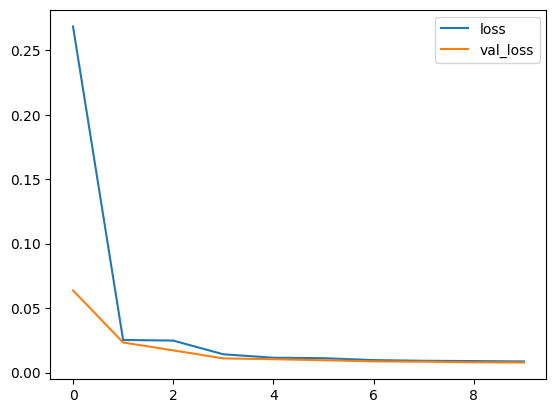

In [29]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## 4.Evaluate on Test Data

In [30]:
first_eval_batch = scaled_train[-length:]

In [31]:
first_eval_batch

array([[0.48092212, 0.47938303, 0.54599069, 0.43973838, 0.45654066,
        0.45201398, 0.50293391, 0.43443782, 0.39746428, 0.4544148 ,
        0.51321806, 0.4960733 , 0.50576093, 0.51738507, 0.47446736,
        0.46406193, 0.4706704 , 0.45272084, 0.49847868, 0.47227834,
        0.40721386, 0.51886022, 0.46034312, 0.47484129, 0.34219914,
        0.44504553, 0.37944574, 0.46925802, 0.3694788 , 0.49261405,
        0.40664844, 0.4581912 ],
       [0.51682264, 0.47657638, 0.63267877, 0.42072971, 0.43244958,
        0.45082009, 0.50909811, 0.45728405, 0.30385271, 0.43843241,
        0.47725723, 0.46876658, 0.49028201, 0.43552448, 0.45629526,
        0.50926359, 0.47129713, 0.41644392, 0.52124584, 0.52986621,
        0.43639833, 0.49610487, 0.40808117, 0.51252143, 0.40724448,
        0.40763699, 0.4317412 , 0.43557179, 0.49518611, 0.39110489,
        0.37945584, 0.47189025],
       [0.63285703, 0.56422817, 0.61534469, 0.57074083, 0.54989834,
        0.56997671, 0.55319372, 0.72957316, 0.3664

In [32]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [33]:
model.predict(first_eval_batch)

1/1 [==============================] - 1s 653ms/step


array([[0.6668999 , 0.69372094, 0.68106246, 0.8199233 , 0.71623975,
        0.6672425 , 0.7024827 , 0.5051059 , 0.7343831 , 0.6760615 ,
        0.7982624 , 0.68987334, 0.6838443 , 0.73129267, 0.7149899 ,
        0.8427264 , 0.79602706, 0.6974239 , 0.72384757, 0.7842504 ,
        0.6963509 , 0.758877  , 0.77062464, 0.7619512 , 0.70037055,
        0.72014654, 0.6407311 , 0.678462  , 0.6485017 , 0.744322  ,
        0.676527  , 0.66762197]], dtype=float32)

In [34]:
scaled_test[0]

array([0.67613358, 0.72584804, 0.769549  , 0.71010773, 0.67140588,
       0.64860501, 0.73428209, 0.6323644 , 0.69480102, 0.77418678,
       0.78087126, 0.72420285, 0.84669367, 0.72864908, 0.68611754,
       0.80651245, 0.78582348, 0.68708356, 0.71986225, 0.79971399,
       0.73350088, 0.72694678, 0.81791842, 0.79458939, 0.6410945 ,
       0.68744229, 0.62044861, 0.69317857, 0.88264859, 0.69928702,
       0.71450213, 0.7109771 ])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [35]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 36ms/step


In [36]:
test_predictions

[array([0.6668999 , 0.69372094, 0.68106246, 0.8199233 , 0.71623975,
        0.6672425 , 0.7024827 , 0.5051059 , 0.7343831 , 0.6760615 ,
        0.7982624 , 0.68987334, 0.6838443 , 0.73129267, 0.7149899 ,
        0.8427264 , 0.79602706, 0.6974239 , 0.72384757, 0.7842504 ,
        0.6963509 , 0.758877  , 0.77062464, 0.7619512 , 0.70037055,
        0.72014654, 0.6407311 , 0.678462  , 0.6485017 , 0.744322  ,
        0.676527  , 0.66762197], dtype=float32),
 array([0.66973686, 0.70222193, 0.6859526 , 0.8242921 , 0.7283243 ,
        0.67008996, 0.6993824 , 0.50712246, 0.73294026, 0.6846101 ,
        0.80101293, 0.68793917, 0.6843234 , 0.7414751 , 0.72122216,
        0.8502306 , 0.8065549 , 0.7032675 , 0.73001194, 0.7916369 ,
        0.70200014, 0.77196234, 0.77651995, 0.7700549 , 0.7027029 ,
        0.7212856 , 0.64445513, 0.6875251 , 0.6459225 , 0.74833024,
        0.682421  , 0.66593283], dtype=float32),
 array([0.67335665, 0.70989054, 0.68840396, 0.8302506 , 0.7342073 ,
        0.6736475 

In [37]:
scaled_test

array([[0.67613358, 0.72584804, 0.769549  , 0.71010773, 0.67140588,
        0.64860501, 0.73428209, 0.6323644 , 0.69480102, 0.77418678,
        0.78087126, 0.72420285, 0.84669367, 0.72864908, 0.68611754,
        0.80651245, 0.78582348, 0.68708356, 0.71986225, 0.79971399,
        0.73350088, 0.72694678, 0.81791842, 0.79458939, 0.6410945 ,
        0.68744229, 0.62044861, 0.69317857, 0.88264859, 0.69928702,
        0.71450213, 0.7109771 ],
       [0.67845716, 0.6467147 , 0.62485623, 0.55043784, 0.67998717,
        0.6138991 , 0.6775013 , 0.71266718, 0.64934515, 0.76776862,
        0.71748207, 0.64681131, 0.810403  , 0.64043619, 0.64620335,
        0.78437447, 0.75897011, 0.63477071, 0.70701611, 0.57134283,
        0.74696525, 0.6510446 , 0.76783836, 0.73944538, 0.57036323,
        0.56752042, 0.58550653, 0.6260636 , 0.90169763, 0.59742529,
        0.74695207, 0.6790414 ],
       [0.75690393, 0.67076226, 0.6178536 , 0.63228308, 0.72134678,
        0.65509811, 0.74396355, 0.85771269, 0.6804

## 5.Inverse Transformations and Compare

In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
true_predictions

array([[2.02810377e+09, 3.61717401e+08, 3.02819063e+08, 1.20315103e+08,
        5.40484534e+08, 2.93324592e+08, 4.20697485e+07, 1.18391162e+08,
        7.21667712e+07, 4.76679455e+07, 6.15715117e+08, 5.89879508e+07,
        4.35646048e+08, 8.09055827e+07, 5.65639711e+07, 2.29315878e+08,
        5.45715416e+08, 1.08592102e+08, 1.27286283e+08, 1.37601478e+08,
        2.65560733e+08, 1.61752365e+08, 4.84160862e+07, 1.53481809e+08,
        2.86014756e+08, 1.25843387e+08, 4.21090640e+08, 1.15904039e+08,
        2.25080665e+08, 1.43404503e+08, 1.22403776e+08, 8.22943849e+09],
       [2.03248559e+09, 3.63627118e+08, 3.03593591e+08, 1.20597610e+08,
        5.44734576e+08, 2.93950863e+08, 4.19980226e+07, 1.18535639e+08,
        7.21029233e+07, 4.79044308e+07, 6.16687126e+08, 5.89134011e+07,
        4.35755173e+08, 8.14242604e+07, 5.67982522e+07, 2.30158019e+08,
        5.48809768e+08, 1.09027635e+08, 1.27797202e+08, 1.38016831e+08,
        2.66507961e+08, 1.62879965e+08, 4.85549204e+07, 1.54180

In [40]:
test

,تهران,آذربایجان شرقی,آذربایجان غربی,اردبیل,اصفهان,البرز,ایلام,بوشهر,چهارمحال و بختیاری,خراسان جنوبی,...,کهگیلویه و بویر احمد,گلستان,گیلان,لرستان,مازندران,مرکزی,هرمزگان,همدان,یزد,مجموع
2023-11-01,2042365685.145955,368934640.61071,316834049.738789,113213976.89139,524716806.236484,289225413.400442,42805437.934077,127508682.215485,70415214.73588,50382440.627179,...,49529850.250762,156294646.880433,276584585.664674,123162773.666713,415316128.842057,117081631.243608,257992849.525178,139341925.241224,125298562.034495,8457885204.084438
2023-12-01,2045954579.874464,351157616.137109,293916810.353055,102889063.750059,527734780.048947,281592115.468826,41491795.58858,133262028.72965,68403736.23834,50204891.558563,...,48350469.656124,151542202.464135,265332016.131016,113333344.419134,405367965.842398,111711206.37287,260670422.132411,130153042.350004,127772171.700396,8289609728.094483
2024-01-01,2167120022.025641,356559816.03385,292807694.228397,108181514.444722,542280637.293233,290653520.478678,43029421.723637,143653912.482905,69778780.35426,51258622.26902,...,49545358.227318,150342120.888727,280331905.200506,116437471.912616,425501768.039688,115122411.897841,298286766.360848,132267091.202741,130990844.985036,8613289888.130478
2024-02-01,2795459033.87058,481696266.300162,369966699.628096,146639337.197898,687267355.455282,398608706.555262,56857245.54962,167364223.947846,98200689.735889,62700145.794557,...,61909572.47387,189505649.855273,350120005.167346,165015592.534187,543543108.526482,154940408.147057,321920956.465215,181497850.771568,167381018.539086,10918507216.936815


In [41]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [42]:
true_predictions

,تهران,آذربایجان شرقی,آذربایجان غربی,اردبیل,اصفهان,البرز,ایلام,بوشهر,چهارمحال و بختیاری,خراسان جنوبی,...,کهگیلویه و بویر احمد,گلستان,گیلان,لرستان,مازندران,مرکزی,هرمزگان,همدان,یزد,مجموع
0,2.028104e+09,3.617174e+08,3.028191e+08,1.203151e+08,5.404845e+08,2.933246e+08,4.206975e+07,1.183912e+08,7.216677e+07,4.766795e+07,...,4.841609e+07,1.534818e+08,2.860148e+08,1.258434e+08,4.210906e+08,1.159040e+08,2.250807e+08,1.434045e+08,1.224038e+08,8.229438e+09
1,2.032486e+09,3.636271e+08,3.035936e+08,1.205976e+08,5.447346e+08,2.939509e+08,4.199802e+07,1.185356e+08,7.210292e+07,4.790443e+07,...,4.855492e+07,1.541802e+08,2.863858e+08,1.259367e+08,4.221509e+08,1.166292e+08,2.247181e+08,1.437661e+08,1.228531e+08,8.220538e+09
2,2.038077e+09,3.653498e+08,3.039819e+08,1.209829e+08,5.468036e+08,2.947333e+08,4.206143e+07,1.186657e+08,7.222073e+07,4.800648e+07,...,4.862054e+07,1.544272e+08,2.866802e+08,1.262003e+08,4.233035e+08,1.172320e+08,2.249538e+08,1.443463e+08,1.231413e+08,8.239536e+09
3,2.041513e+09,3.664431e+08,3.042612e+08,1.212576e+08,5.484044e+08,2.951630e+08,4.209505e+07,1.188170e+08,7.232445e+07,4.808976e+07,...,4.866472e+07,1.546316e+08,2.868917e+08,1.263629e+08,4.241383e+08,1.176278e+08,2.251582e+08,1.447244e+08,1.233451e+08,8.251756e+09


In [56]:
model.save("multivariate.h5")